In [60]:
!pip install pandas

In [61]:
!pip install matplotlib

In [62]:
!pip install seaborn

In [63]:
!pip install nltk

In [64]:
!pip install scikit-learn

In [65]:
!pip install sentence-transformers -q

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
import time
import pickle
import joblib
import json
from datetime import datetime
import os
from sentence_transformers import SentenceTransformer
import torch
from sklearn.model_selection import train_test_split
from collections import Counter

#Загружаем датасеты

In [67]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.info())
print('-------------')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10780 entries, 0 to 10779
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           10780 non-null  object
 1   subject      10780 non-null  object
 2   body         10780 non-null  object
 3   text         10780 non-null  object
 4   category     10780 non-null  object
 5   category_id  10780 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 505.4+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2697 entries, 0 to 2696
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2697 non-null   object
 1   subject      2697 non-null   object
 2   body         2697 non-null   object
 3   text         2697 non-null   object
 4   category     2697 non-null   object
 5   category_id  2697 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 126.6+ KB
None


#Анализ данных

Пропуски: 0
Дубликаты: 0

Распределение категорий:
category
verify_code     1800
forum           1800
social_media    1796
promotions      1796
spam            1794
updates         1794
Name: count, dtype: int64


/tmp/ipython-input-3959087417.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


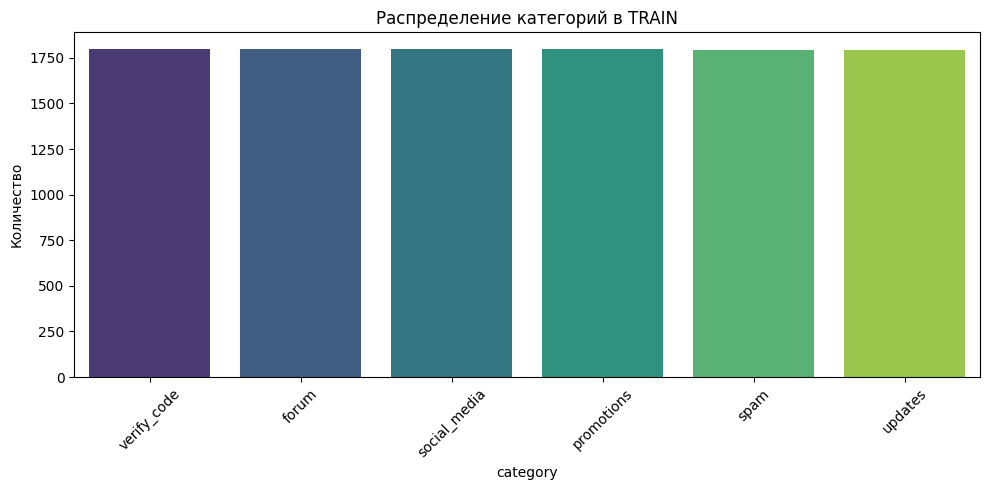

Мин: 7
Макс: 236
Среднее: 16
Медиана: 16


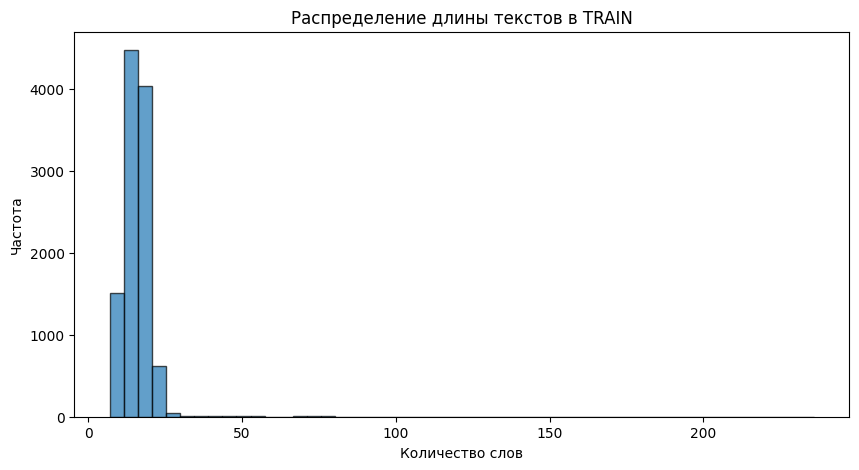

Пропуски: 0
Дубликаты: 0

Распределение категорий:
category
verify_code     451
forum           450
social_media    449
updates         449
promotions      449
spam            449
Name: count, dtype: int64


/tmp/ipython-input-3959087417.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


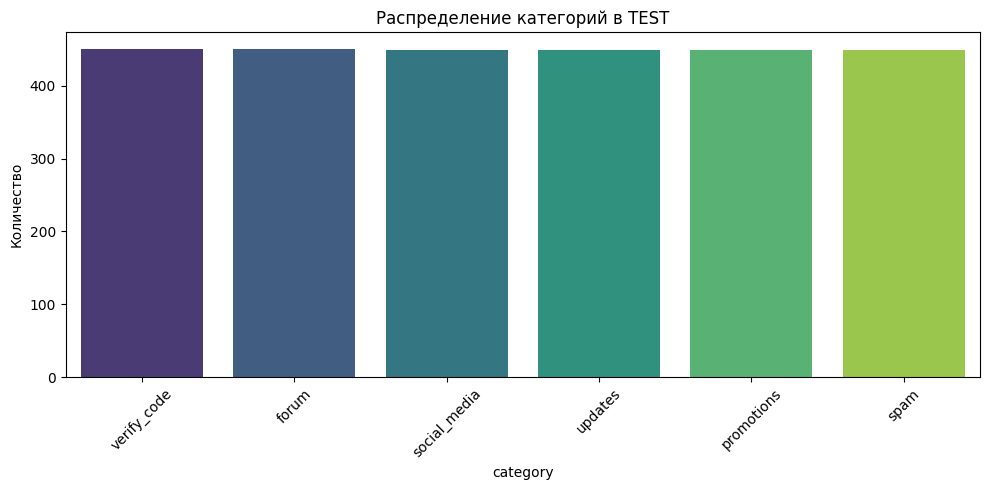

Мин: 7
Макс: 249
Среднее: 16
Медиана: 16


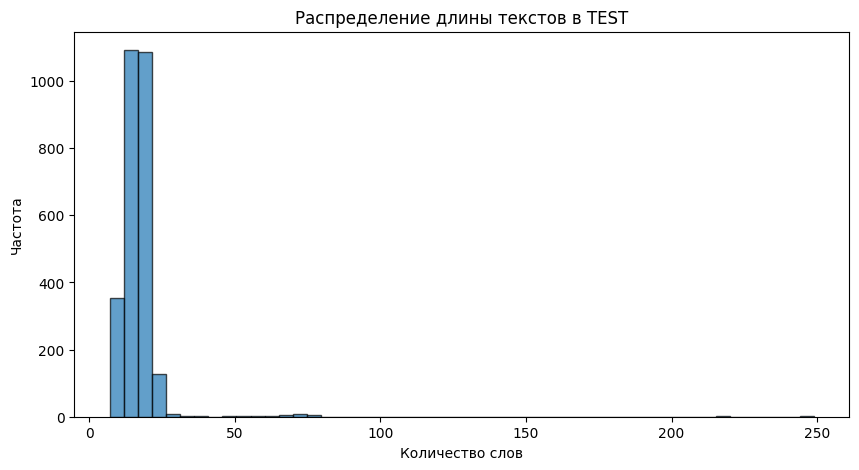

In [68]:
def analysis(df, dataset_name):
    print(f"Пропуски: {df.isnull().sum().sum()}")
    print(f"Дубликаты: {df.duplicated().sum()}")

    if 'category' in df.columns:
        print(f"\nРаспределение категорий:")
        category_counts = df['category'].value_counts()
        print(category_counts)

        plt.figure(figsize=(10, 5))
        sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
        plt.title(f'Распределение категорий в {dataset_name}')
        plt.xticks(rotation=45)
        plt.ylabel('Количество')
        plt.tight_layout()
        plt.show()

    if 'text' in df.columns:
        df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
        print(f"Мин: {df['text_length'].min()}")
        print(f"Макс: {df['text_length'].max()}")
        print(f"Среднее: {df['text_length'].mean():.0f}")
        print(f"Медиана: {df['text_length'].median():.0f}")

        plt.figure(figsize=(10, 5))
        plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
        plt.title(f'Распределение длины текстов в {dataset_name}')
        plt.xlabel('Количество слов')
        plt.ylabel('Частота')
        plt.show()

analysis(train_df, "TRAIN")
analysis(test_df, "TEST")

#Очистка текста

In [69]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('punkt')
    nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('english'))

def clean_email_text(text):
    if pd.isna(text):
        return ""

    text = str(text)

    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)

    words = text.split()
    words = [word for word in words if word not in STOP_WORDS and len(word) > 2]

    return ' '.join(words)

train_df['clean_text'] = train_df['text'].apply(clean_email_text)
test_df['clean_text'] = test_df['text'].apply(clean_email_text)

In [71]:

vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['category'])
y_test = label_encoder.transform(test_df['category'])

print(f"Категории: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

Категории: {'forum': 0, 'promotions': 1, 'social_media': 2, 'spam': 3, 'updates': 4, 'verify_code': 5}


#Тестим несколько моделей

In [72]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'Linear SVM': LinearSVC(max_iter=1000, random_state=42),
    'Multinomial NB': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    start_time = time.time()
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    train_time = time.time() - start_time

    results[name] = {
        'accuracy': accuracy,
        'time': train_time,
        'model': model,
        'predictions': y_pred
    }

    print(f"Точность: {accuracy:.4f}")
    print(f"Время обучения: {train_time:.2f} сек")

best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nЛучшая модель: {best_model_name} (accuracy: {results[best_model_name]['accuracy']:.4f})")


Logistic Regression
Точность: 0.9822
Время обучения: 1.82 сек

Random Forest
Точность: 0.9800
Время обучения: 2.87 сек

Linear SVM
Точность: 0.9837
Время обучения: 0.22 сек

Multinomial NB
Точность: 0.9781
Время обучения: 0.01 сек

Gradient Boosting
Точность: 0.9670
Время обучения: 62.34 сек

Лучшая модель: Linear SVM (accuracy: 0.9837)



Linear SVM:
              precision    recall  f1-score   support

       forum       0.97      0.98      0.97       450
  promotions       0.99      1.00      0.99       449
social_media       0.99      0.98      0.98       449
        spam       0.98      0.98      0.98       449
     updates       0.97      0.98      0.98       449
 verify_code       0.99      1.00      0.99       451

    accuracy                           0.98      2697
   macro avg       0.98      0.98      0.98      2697
weighted avg       0.98      0.98      0.98      2697



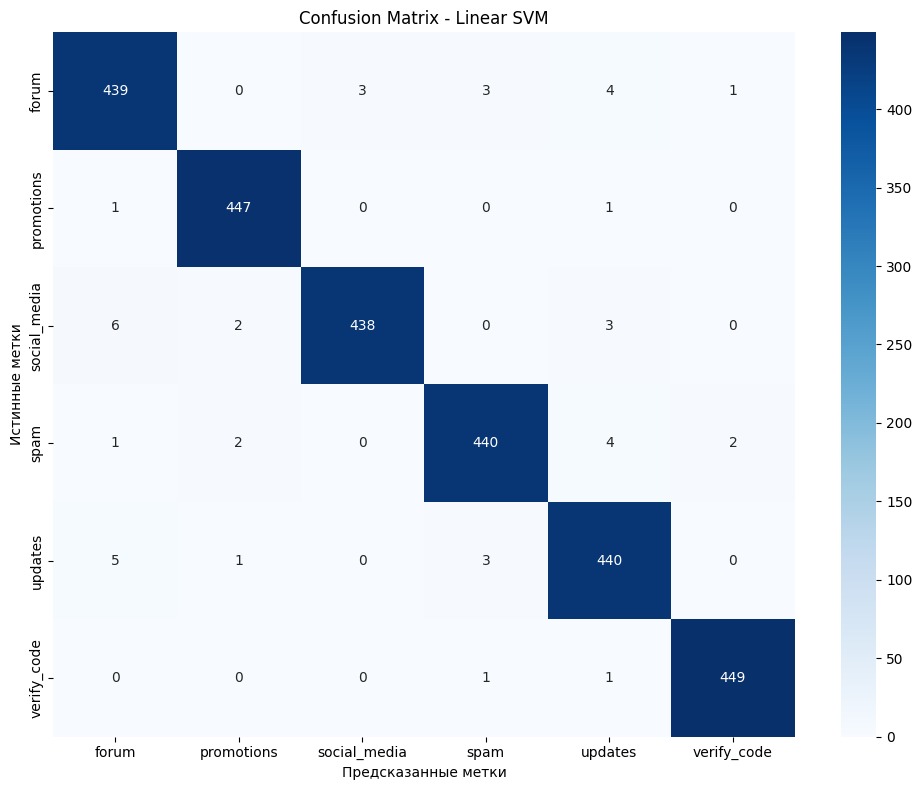

  social_media → forum: 6 раз
  updates → forum: 5 раз
  spam → updates: 4 раз
  forum → updates: 4 раз
  forum → spam: 3 раз


In [73]:
best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['predictions']

print(f"\n{best_model_name}:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.tight_layout()
plt.show()

errors = []
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        true_label = label_encoder.inverse_transform([y_test[i]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
        errors.append((true_label, pred_label))


error_counts = Counter(errors)
for (true, pred), count in error_counts.most_common(5):
    print(f"  {true} → {pred}: {count} раз")

#Валидация

In [74]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.15,
    random_state=42,
    stratify=y_train
)

best_model.fit(X_train_final, y_train_final)

y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nПроизводительность на валидации: {val_accuracy:.4f}")

y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Финальная точность на тесте: {test_accuracy:.4f}")


Производительность на валидации: 0.9827
Финальная точность на тесте: 0.9841


In [75]:
model_dir = f"email_classifier_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(best_model, f'{model_dir}/model.pkl')

with open(f'{model_dir}/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open(f'{model_dir}/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

metadata = {
    'model_name': best_model_name,
    'accuracy': float(test_accuracy),
    'train_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'features': X_train.shape[1],
    'categories': label_encoder.classes_.tolist(),
    'created_at': datetime.now().isoformat()
}

with open(f'{model_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nМодель сохранена в директории: {model_dir}")
print(f"Сохраненные файлы:")
for file in os.listdir(model_dir):
    print(f"  - {file}")


Модель сохранена в директории: email_classifier_20251223_214623
Сохраненные файлы:
  - vectorizer.pkl
  - metadata.json
  - model.pkl
  - label_encoder.pkl
